# 레이어를 깊게 쌓기 위한 노오력들

이런 노력들이 모여 오늘날 GPT같은 거대한 모델을 만들 수 있었습니다.   
일부 노력들을 소개합니다.

# (늘 하던 대로) 준비

In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [5]:
names = open('../names.txt').read().splitlines()
chars = list(set(''.join(names)))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [6]:
def build_dataset(words):
    block_size = 3
    X,Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size

        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', ch)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [7]:
import random
random.seed(42)
random.shuffle(names)
n1 = int(len(names)*0.8)
n2 = int(len(names)*0.9)

Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xte, Yte = build_dataset(names[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# 첫번째 학습 스텝 loss 최소화하기

In [8]:
block_size = 3
vocab_size = 27
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [9]:
# 첫번째 step loss 구하기
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += - lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    if i==20000:
        break

      0/ 200000: 25.8507
  10000/ 200000: 2.9469
  20000/ 200000: 2.6619


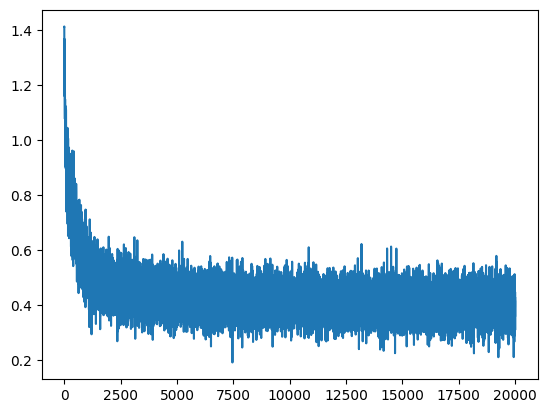

In [10]:
plt.plot(lossi)

In [11]:
@torch.no_grad
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.4960274696350098
val 2.511521577835083


첫번째 스텝 학습 loss 혼자 너무 큽니다.   
처음 가중치 초기화했을 때 랜덤이라   
logit에서 올바르지 않은 값이 높기 때문입니다.

## logits을 모두 비슷한 값으로 하면 loss 작아짐
예시로 4차원 logits을 봅시다.

In [12]:
# 랜덤한 logit (가중치 초기화)
logits = torch.randn(4)
probs = F.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([ 0.3782,  0.1767, -0.5075, -1.2099]),
 tensor([0.4108, 0.3358, 0.1694, 0.0839]),
 tensor(1.7753))

위 셀을 실행할 때마다 편차가 심하고, loss 값이 클 때도 많습니다.

In [13]:
logits = torch.tensor([0,0,0,0]).float()
probs = F.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([0., 0., 0., 0.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

모델 가중치 초기화할 때   
최대한 output layer 가중치를 작은 값으로 하면   
첫번째 학습 스텝에서 lgotis 값이 모두 0에 가까워지고, 작은 loss를 보장할 수 있습니다.

In [14]:
block_size = 3
vocab_size = 27
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [15]:
# 첫번째 step loss 구하기
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += - lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    if i==20000:
        break

      0/ 200000: 3.3147
  10000/ 200000: 2.1962
  20000/ 200000: 2.2236


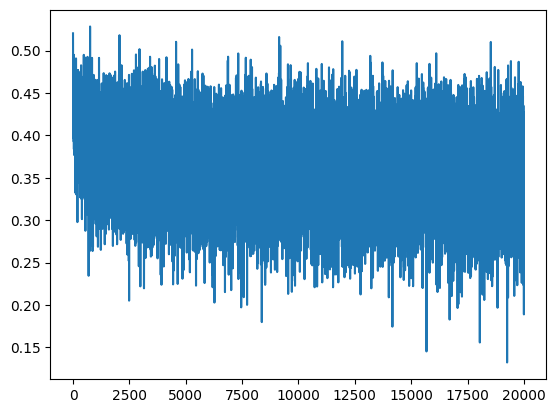

In [16]:
plt.plot(lossi)

In [17]:
@torch.no_grad
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2533693313598633
val 2.281580686569214


# tanh의 초기 saturation 문제
첫번째 스텝 학습해보면   
`tanh`가 문제라는 걸 알 수 있습니다.

In [18]:
block_size = 3
vocab_size = 27
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [19]:
# 첫번째 step loss 구하기
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += - lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.3147


(array([  1.,   0.,   0.,   1.,   0.,   2.,   4.,   2.,   1.,   8.,  13.,
         24.,  25.,  33.,  66.,  54.,  68., 108., 153., 183., 228., 220.,
        304., 263., 364., 378., 385., 434., 426., 402., 379., 335., 305.,
        283., 190., 189., 160., 133.,  70.,  64.,  38.,  31.,  18.,  13.,
          9.,  13.,   8.,   6.,   3.,   3.]),
 array([-23.18888664, -22.33743259, -21.48597855, -20.6345245 ,
        -19.78307045, -18.9316164 , -18.08016235, -17.22870831,
        -16.37725426, -15.52580021, -14.67434616, -13.82289211,
        -12.97143806, -12.11998402, -11.26852997, -10.41707592,
         -9.56562187,  -8.71416782,  -7.86271378,  -7.01125973,
         -6.15980568,  -5.30835163,  -4.45689758,  -3.60544353,
         -2.75398949,  -1.90253544,  -1.05108139,  -0.19962734,
          0.65182671,   1.50328075,   2.3547348 ,   3.20618885,
          4.0576429 ,   4.90909695,   5.76055099,   6.61200504,
          7.46345909,   8.31491314,   9.16636719,  10.01782124,
         10.869275

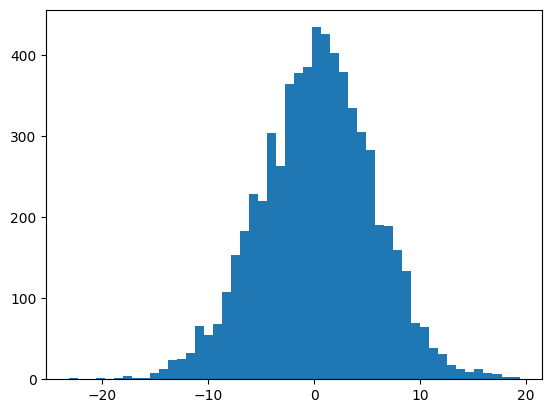

In [20]:
# tanh 입력값 hpreact 분포 확인 (tanh 그래프와 함께 봅시다)
plt.hist(hpreact.view(-1).tolist(), bins=50)

In [21]:
# tanh 입력값이 5만 넘어도 이미 0.9999
torch.tanh(torch.tensor([5])), torch.tanh(torch.tensor([-5]))

(tensor([0.9999]), tensor([-0.9999]))

(array([2101.,  154.,   99.,   74.,   57.,   49.,   42.,   27.,   24.,
          31.,   23.,   21.,   19.,   25.,   27.,   28.,   21.,   20.,
          32.,   14.,   15.,   31.,   27.,   22.,   21.,   19.,   12.,
          22.,   20.,   15.,   14.,   27.,   31.,   23.,   18.,   26.,
          31.,   24.,   24.,   41.,   24.,   42.,   36.,   39.,   51.,
          66.,   81.,  102.,  181., 2427.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

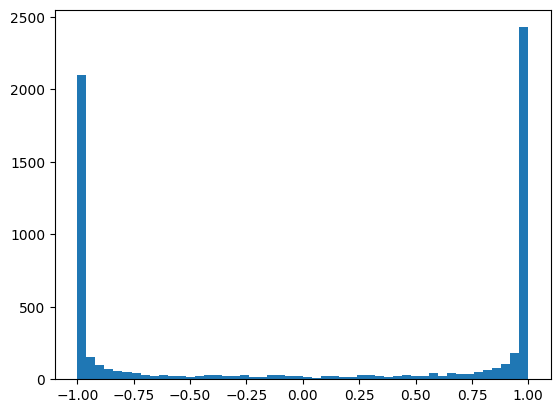

In [22]:
# h값 분포 확인
plt.hist(h.view(-1).tolist(), bins=50)

$\text{tanh}$ 값이 -1과 1에 치우쳐져 있으면 gradient가 0이 되어 학습이 잘 안됩니다.   
$\text{tanh}(x)$ 미분하면 $1-\text{tanh}^2(x)$라서   
$\text{tanh}$ 값이 1과 -1에 가까울수록 기울기가 0 $\rightarrow$ 학습이 잘 안됩니다

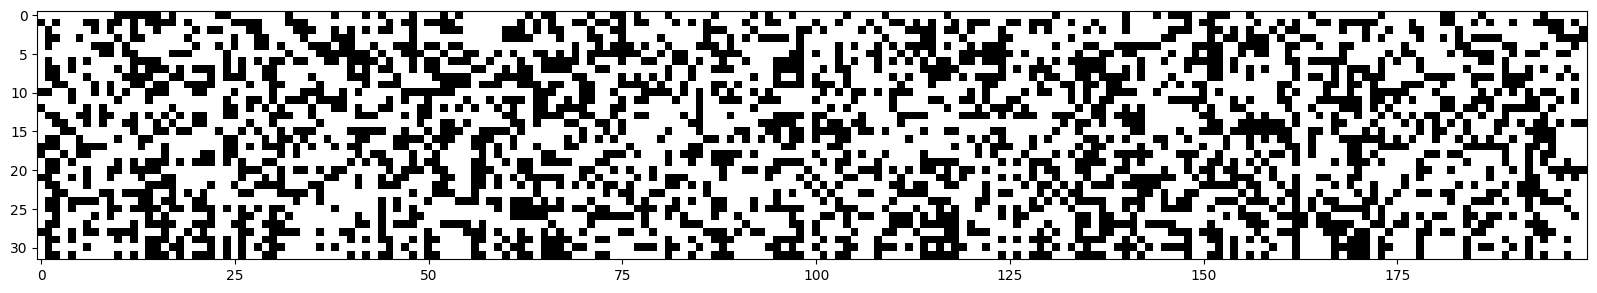

In [23]:
# h의 절댓값 중 0.99 이상인 것 확인
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

위 그림에서 흰 부분이 $h>0.99$, 즉 그레디언트가 0에 가까운 부분입니다.   
그렇게 되면 `tanh` 그레디언트에 영향을 받는 `W1`, `b1`의 그레디언트도 매우 작아집니다.   
지금은 모델 층이 깊지 않아서 괜찮아보이지만   
층이 깊어질수록 이 문제는 더 심해집니다.   

In [24]:
W1.grad, b1.grad

(tensor([[-2.7800e-04,  1.0058e-03, -3.1641e-04,  ...,  5.0824e-04,
          -1.3011e-04,  2.4327e-04],
         [ 7.1995e-05, -2.7981e-04,  5.9726e-04,  ...,  6.5304e-05,
          -2.8413e-04, -1.1373e-04],
         [ 9.7173e-05, -1.2456e-04,  5.2087e-04,  ...,  1.0245e-04,
          -3.0285e-05,  5.5406e-05],
         ...,
         [-6.4242e-04, -1.0741e-03, -1.4470e-03,  ..., -5.2798e-04,
           5.5635e-04, -3.3712e-04],
         [ 5.2078e-04, -1.4453e-05,  1.5010e-03,  ...,  2.6710e-04,
          -1.6532e-04, -5.0202e-05],
         [ 7.1931e-05,  7.8326e-05, -3.7792e-04,  ...,  1.9532e-04,
          -4.1924e-04, -4.7547e-05]]),
 tensor([-4.8677e-04, -1.6949e-04, -1.5007e-03, -6.4867e-05,  4.2608e-04,
         -3.6305e-04,  1.6332e-04, -5.6611e-04,  2.3736e-04, -3.2549e-04,
         -2.1908e-04, -4.4992e-04,  7.3902e-04,  2.6189e-04, -4.4513e-04,
         -4.1898e-04,  3.0986e-04,  5.5389e-04,  4.7016e-04, -3.6421e-04,
          9.4902e-04,  9.0662e-04, -4.8242e-05,  2.2151e-0

In [25]:
W2.grad, b2.grad

(tensor([[ 0.0145, -0.0120, -0.0132,  ..., -0.0039,  0.0159, -0.0126],
         [ 0.1810, -0.0027, -0.0020,  ...,  0.0353, -0.0307, -0.0010],
         [ 0.0266, -0.0044, -0.0037,  ..., -0.0027,  0.0015, -0.0300],
         ...,
         [ 0.2021, -0.0184, -0.0167,  ...,  0.0445, -0.0131,  0.0099],
         [ 0.1137,  0.0057,  0.0075,  ..., -0.0540, -0.0259,  0.0059],
         [-0.1410,  0.0279,  0.0267,  ..., -0.0345, -0.0016, -0.0358]]),
 tensor([-0.2448,  0.0372,  0.0358, -0.0219,  0.0045, -0.0592, -0.0276,  0.0065,
          0.0075, -0.0573,  0.0359,  0.0435,  0.0360,  0.0344,  0.0058,  0.0069,
          0.0342,  0.0060,  0.0381,  0.0050,  0.0361,  0.0391,  0.0055,  0.0375,
         -0.0264,  0.0084, -0.0267]))

## 해결책: hpreact 값을 0 주변으로 모이게 만들기

`tanh`의 입력값(hpreact)을 0 주변으로 하면   
`tanh`가 1 또는 -1이 안되겠죠?

`W1`, `b1`을 작게 하면 됩니다.

In [26]:
block_size = 3
vocab_size = 27
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [27]:
# 첫번째 step loss 구하기
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += - lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.3024


(array([  1.,   0.,   0.,   0.,   3.,   3.,   2.,   4.,   6.,   8.,  17.,
         28.,  28.,  49.,  47.,  74., 100., 121., 157., 201., 231., 241.,
        297., 292., 355., 412., 405., 419., 427., 375., 328., 307., 297.,
        259., 205., 175., 135., 104.,  85.,  57.,  40.,  30.,  20.,  12.,
         10.,  12.,   8.,   7.,   2.,   4.]),
 array([-4.36992025, -4.20728131, -4.04464237, -3.88200343, -3.71936449,
        -3.55672555, -3.39408661, -3.23144767, -3.06880873, -2.90616979,
        -2.74353085, -2.5808919 , -2.41825296, -2.25561402, -2.09297508,
        -1.93033614, -1.7676972 , -1.60505826, -1.44241932, -1.27978038,
        -1.11714144, -0.9545025 , -0.79186356, -0.62922462, -0.46658567,
        -0.30394673, -0.14130779,  0.02133115,  0.18397009,  0.34660903,
         0.50924797,  0.67188691,  0.83452585,  0.99716479,  1.15980373,
         1.32244267,  1.48508162,  1.64772056,  1.8103595 ,  1.97299844,
         2.13563738,  2.29827632,  2.46091526,  2.6235542 ,  2.78619314,
 

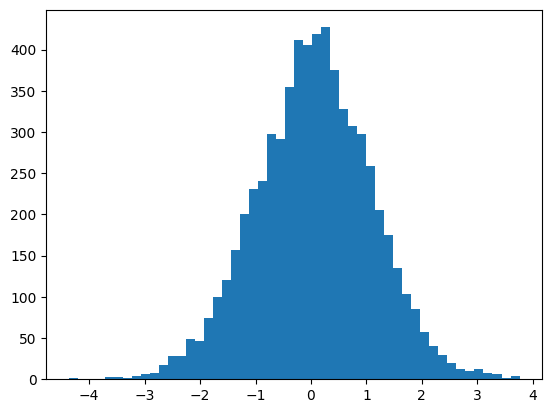

In [28]:
# tanh 입력값 hpreact 분포 확인
plt.hist(hpreact.view(-1).tolist(), bins=50)

(array([189., 187., 177., 162., 154., 135., 144., 123., 105., 115., 118.,
         92., 113.,  87., 104.,  98.,  96.,  96., 119.,  99., 111., 102.,
        114.,  96.,  84., 108.,  85., 120., 110.,  98., 101., 121., 117.,
        119., 100., 124., 102., 122., 122., 110., 106., 145., 133., 165.,
        152., 195., 181., 206., 217., 221.]),
 array([-9.99679863e-01, -9.59707853e-01, -9.19735842e-01, -8.79763831e-01,
        -8.39791820e-01, -7.99819809e-01, -7.59847798e-01, -7.19875787e-01,
        -6.79903777e-01, -6.39931766e-01, -5.99959755e-01, -5.59987744e-01,
        -5.20015733e-01, -4.80043722e-01, -4.40071712e-01, -4.00099701e-01,
        -3.60127690e-01, -3.20155679e-01, -2.80183668e-01, -2.40211657e-01,
        -2.00239646e-01, -1.60267636e-01, -1.20295625e-01, -8.03236139e-02,
        -4.03516030e-02, -3.79592180e-04,  3.95924187e-02,  7.95644295e-02,
         1.19536440e-01,  1.59508451e-01,  1.99480462e-01,  2.39452473e-01,
         2.79424484e-01,  3.19396495e-01,  3.59368

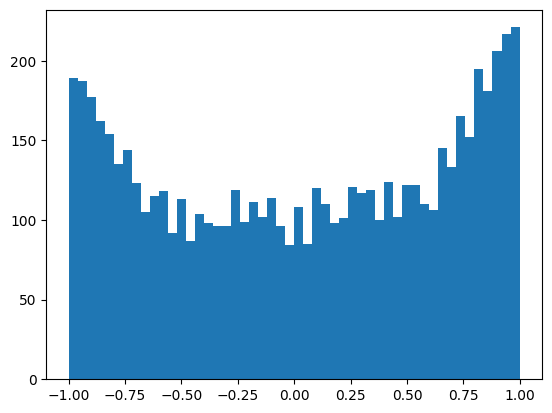

In [29]:
# h값 분포 확인
plt.hist(h.view(-1).tolist(), bins=50)

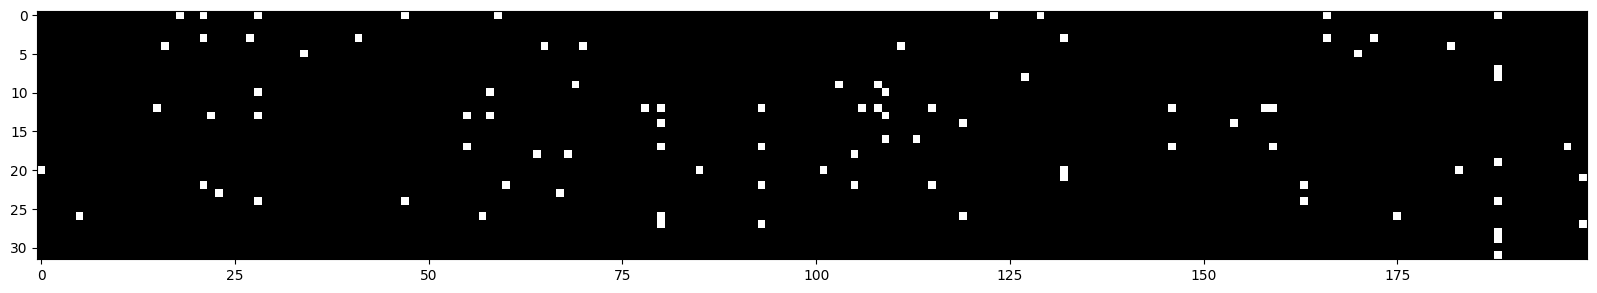

In [30]:
# h의 절댓값 중 0.99 이상인 것 확인
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

In [31]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += - lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    if i==20000:
        break

      0/ 200000: 3.2434
  10000/ 200000: 1.8741
  20000/ 200000: 1.8807


In [32]:
@torch.no_grad
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.198523998260498
val 2.220282554626465


# kaiming initialization (He init)

가중치 값들을 얼마로 시작해야 좋을까요?   
[논문](https://arxiv.org/abs/1502.01852)

## 레이어를 거칠 때마다 분산이 달라진다

한 레이어에는 이런게 있죠
- weight(가중치)
- bias(편향)
- activation function (활성화 함수)   

모델에 입력 $x$를 넣으면   
$activation\_function(x\ @\ W + b)$을 거치면서 분산이 달라집니다.

In [33]:
# 행렬곱은 분산을 키웁니다.
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

tensor(0.0085) tensor(0.9996)
tensor(0.0016) tensor(3.2255)


행렬곱하면서 분산이 1인 확률변수 10개를 더한 것과 같으므로   
분산 $10$, 표준편차 $\sqrt{10} \approx 3.16$

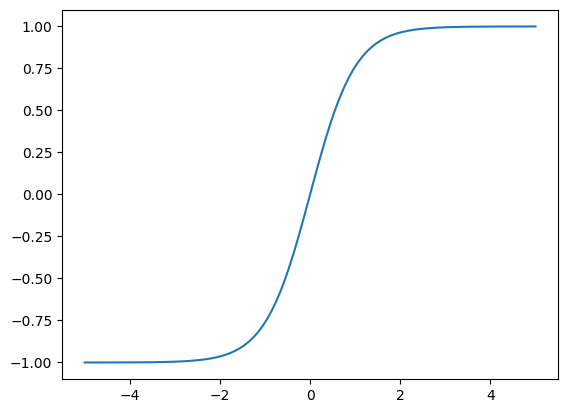

In [34]:
# tanh 활성화 함수 예시
x = torch.linspace(-5, 5, 100)
y = torch.tanh(x)
plt.plot(x, y)

In [35]:
x = torch.randn(100, 100)
print(x.mean(), x.std())
y = torch.tanh(x)
print(y.mean(), y.std()) # std를 3/5로 줄임

tensor(-0.0088) tensor(1.0119)
tensor(-0.0052) tensor(0.6326)


레이어가 깊다면?   
텐서 차원 수가 활성화 함수에 따라서   
분산이 점점 작아지거나 점점 커지겠죠!

## 분산이 극단적이 되면 생기는 문제

파라미터 업데이트는?   
$W \leftarrow W - \text{learning rate} \times \text{gradient}$

- **gradient vanishing:** 그레디언트가 너무 작으면 파라미터 업데이트가 잘 안됩니다.
- **gradient exploding:** 그레디언트 값이 너무 크면 loss 최솟값을 찾지 못하고 발산합니다.

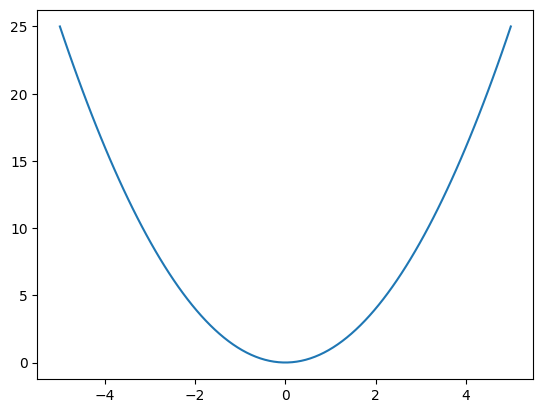

In [36]:
x = torch.linspace(-5, 5, 100)
y = x**2
plt.plot(x, y)

## 레이어를 거쳐도 분산을 최대한 유지하는 게 좋다

- gradient vanishing / exploding 예방
- [모든 레이어가 같은 리듬으로 학습](https://datascience.stackexchange.com/questions/82917/why-do-we-want-the-variance-of-the-layers-to-remain-the-same-throughout-a-deep-n)

## 행렬곱에 맞서 가중치 분산을 줄이자

행렬곱을 하면 가중치의 행 개수 $n_{in}$에 루트 씌운 $\sqrt{n_{in}}$배만큼 표준편차큼 커집니다.   
std gain: $\sqrt{n_{in}}$

예를 들어,   
(1000, 10) @ (10, 200) 행렬곱을 한다면,

표준편차가 $\sqrt{10}$배 됩니다. -> std gain $\sqrt{10}$    
그만큼 줄여주면 됩니다.

In [37]:
x = torch.randn(1000, 10)
# w = torch.randn(10, 200)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

tensor(0.0039) tensor(1.0034)
tensor(0.0003) tensor(1.0122)


## 활성화 함수에 맞서 가중치 분산을 조절하자

[활성화 함수마다 std gain이 다릅니다](https://pytorch.org/docs/stable/nn.init.html)

`tanh`는 $\Large\frac{5}{3}$이니까  
반대로 가중치에 $\Large\frac{3}{5}$를 곱해주면 됩니다.

In [38]:
block_size = 3
vocab_size = 27
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g) * 5/3 / (n_embed*block_size)**0.5
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [39]:
# 첫번째 step loss 구하기
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += - lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    if i==20000:
        break

      0/ 200000: 3.3065
  10000/ 200000: 2.1578
  20000/ 200000: 2.2674


In [40]:
@torch.no_grad
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1880574226379395
val 2.2144510746002197


사실 가중치 초기화는 2015년쯤에는 학습 안정성 때메 중요했지만   
residual connection이나 정규화(배치, 레이어 등), Adam 옵티마이저 때문에 중요성이 떨어졌습니다.   
하지만 std gain을 상쇄하는 개념은 나중에 배울 attention에서도 나오니까 꼭 알아둡시다!!

# batch normalization (배치 정규화)
> 레이어 입력값 분포를 다 정규분포로 만들어버리고 학습하면 알아서 정규분포에 맞게 모델이 최적화되지 않을까?

1. 한 미니 배치별로 표준정규분포로 정규화 (평균 0, 분산 1)
2. scale($\gamma$)과 shift($\beta$)를 학습 $\rightarrow$ 활성화 함수 들어가기 전 레이어별 입력값의 최적의 분포를 찾음

[논문](https://arxiv.org/abs/1502.03167)

여담) [내부 공변량 변화](https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/lecture_notes/Batch_Normalization.pdf)는 논란의 여지가 있어 자세한 설명은 스킵하겠습니다...

(개인적으로, 정규분포는 가장 친숙하기도 하고 평균과 분산으로 조절할 수 있기 때문에 쓰인다고 생각해요!)

## 1. 각 미니 배치마다 값 정규화

$\Large \hat x_i \leftarrow \frac{x_i - \mu_B}{\sqrt{\sigma^2 + \epsilon}}$

크기가 32인 미니 배치에 대해 정규화해봅시다

In [41]:
hpreact.shape

torch.Size([32, 200])

In [42]:
hpreact.mean(), hpreact.std()

(tensor(0.0851, grad_fn=<MeanBackward0>),
 tensor(1.7292, grad_fn=<StdBackward0>))

In [43]:
bnmeani = hpreact.mean(0, keepdim=True)
bnstdi = hpreact.std(0, keepdim=True)

hpreact_norm = (hpreact-bnmeani) / bnstdi

hpreact_norm.mean(), hpreact_norm.std()

(tensor(8.1956e-10, grad_fn=<MeanBackward0>),
 tensor(0.9843, grad_fn=<StdBackward0>))

## 2. 레이어에 맞는 최적의 분포를 학습하자

다음 글자를 예측하는 태스크에서   
레이어 입력값 분포가 꼭 표준정규분포가 최고가 아닐 수 있습니다.   
scale, shift 학습을 통해 가장 적합한 분포를 찾을 수 있습니다.

$\Large\text{BN}_{\gamma, \beta}(x_i) \leftarrow \gamma \hat x + \beta$

In [44]:
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bngain * (hpreact_norm) + bnbias # 지금은 표준정규분포지만 학습하면 달라질 수 있음

tensor([[-0.7913, -0.6390,  0.3496,  ...,  0.2143,  0.3414, -0.3720],
        [ 0.9445,  1.2511,  2.2339,  ..., -0.7674,  0.0292,  1.5745],
        [ 0.9917, -1.5494, -0.3056,  ...,  0.0756, -0.6849, -2.1623],
        ...,
        [ 0.2328,  0.7927, -1.2279,  ..., -0.1055, -0.4937, -0.4453],
        [-0.6174,  1.2564, -0.7203,  ...,  0.9430, -0.8918,  0.3488],
        [-0.2924, -0.6279,  0.5500,  ..., -0.9426, -0.0215,  1.8108]],
       grad_fn=<AddBackward0>)

`bnbias`가 있어서 `b1`은 필요 없어졌습니다

## 배치 정규화 학습

In [45]:
block_size = 3
vocab_size = 27
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g) * 5/3 / (n_embed*block_size)**0.5
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# 학습 다 끝나고 나서 추론할 때 사용할 평균, 표준편차
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


학습 다 끝나고 나서 추론할 때 사용할
- 평균(`bnmean_running`)
- 표준편차(`bnstd_running`)

는 학습 중에 지수이동평균(EMA)로 구합니다!   

모든 학습 데이터에 대해 `hpreact`를 한번에 구하기 어렵고   
미니 배치인 `hpreact`를 만날 때마다 EMA로 구하는게 편하기 때문입니다.   
> 은사님: everybody is lazy

In [46]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)

    hpreact = embcat @ W1 #+ b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact-bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += - lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    
    if i == 20000: break

      0/ 200000: 3.3047
  10000/ 200000: 2.1212
  20000/ 200000: 2.5821


In [47]:
split_loss('train')
split_loss('val')

train 2.483656167984009
val 2.488983154296875


## batch normalization 단점
너무 미니 배치 분포에 의존합니다. (coupling)

- 추론할 때는 학습에서 구한 `bnmean_running`, `bnstd_running`을 사용합니다 $\rightarrow$ 추론 데이터랑 안맞을 수 있어요
- 만약 미니 배치 사이즈가 매우 작으면…? 평균, 표준편차가 제대로 학습 데이터 분포를 나타내지 않습니다.

이제는 layer normalization, RMS normalization, instance normalization, group normalization 같은 방식을 많이 씁니다.

batch norm이 처음으로 층이 깊을 때 잘 학습할 수 있는 방법으로 나와서 소개드렸습니다.

# 파이토치처럼 신경망 클래스 만들기

In [48]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [49]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)

            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar

        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x-xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [50]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [51]:
vocab_size = 27
n_embed = 10
block_size = 3
n_hidden = 100

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain of tanh
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [52]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # for debugging
    for p in parameters:
        p.grad=None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break # for debugging

      0/ 200000: 3.3175


# forward & backward pass activation 시각화

딱 한 스텝 업데이트했을 때   
tanh 아웃풋과 그레디언트 그려봅시다.   
(tanh 값이 0.97보다 크면 포화라고 가정)

1. tanh 값이 x축이고 빈도가 y축
2. 기울기 값이 x축이고 빈도가 y축

## kaiming init 적용한 경우

layer 1 Tanh      : mean: -0.06, std: 0.75, saturated: 20.22%


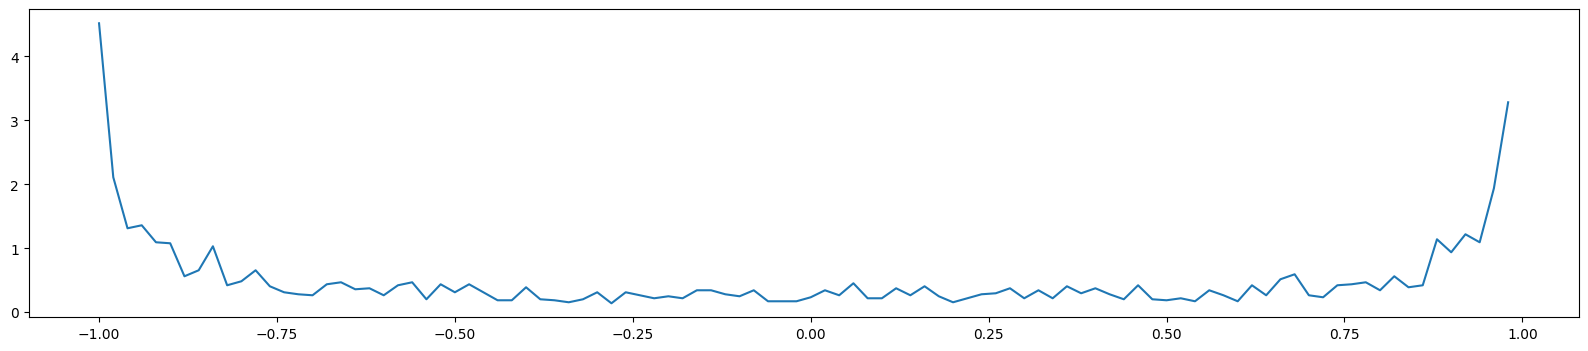

In [53]:
# 1번째 레이어(Tanh) 값 그려보기
plt.figure(figsize=(20,4))

layer = layers[1]
t = layer.out
print(f'layer 1 {layer.__class__.__name__:10s}: mean: {t.mean():.2f}, std: {t.std():.2f}, saturated: {(t.abs()>0.97).float().mean()*100:.2f}%')
hy, hx = torch.histogram(t, density=True) # histogram count, bin edges
plt.plot(hx[:-1].detach(), hy.detach()) # hx가 hy보다 숫자 하나 더 많아서 맞춰줍니다.

layer 1 Tanh      : mean: -0.06, std: 0.75, saturated: 20.22%
layer 3 Tanh      : mean: 0.02, std: 0.69, saturated: 8.28%
layer 5 Tanh      : mean: 0.01, std: 0.67, saturated: 7.31%
layer 7 Tanh      : mean: -0.00, std: 0.65, saturated: 5.75%
layer 9 Tanh      : mean: 0.02, std: 0.65, saturated: 6.09%


Text(0.5, 1.0, 'activation distribution')

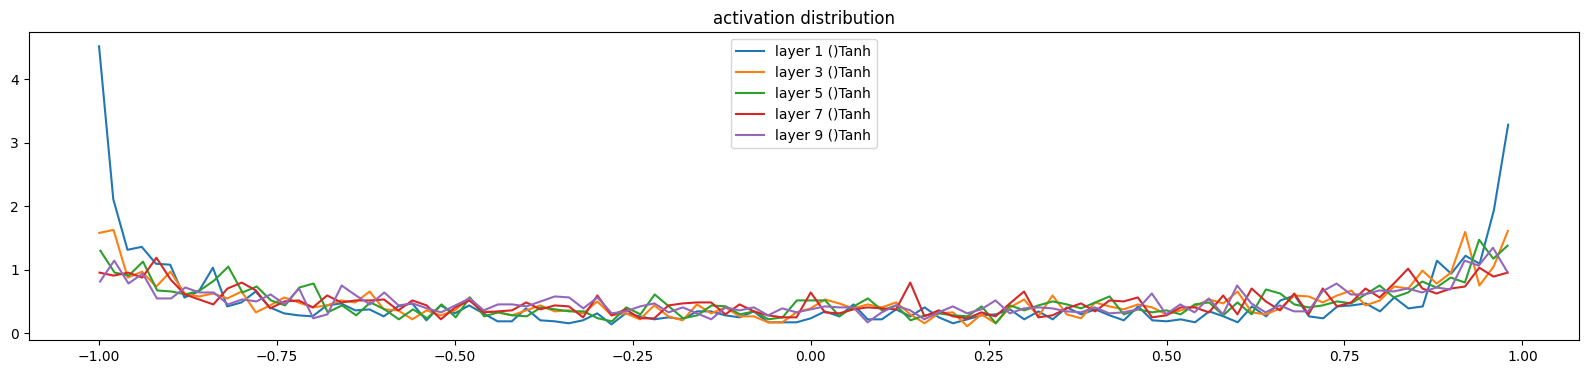

In [54]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} {layer.__class__.__name__:10s}: mean: {t.mean():.2f}, std: {t.std():.2f}, saturated: {(t.abs()>0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

layer 1 Tanh      : mean: +0.000011, std: 4.397009e-04


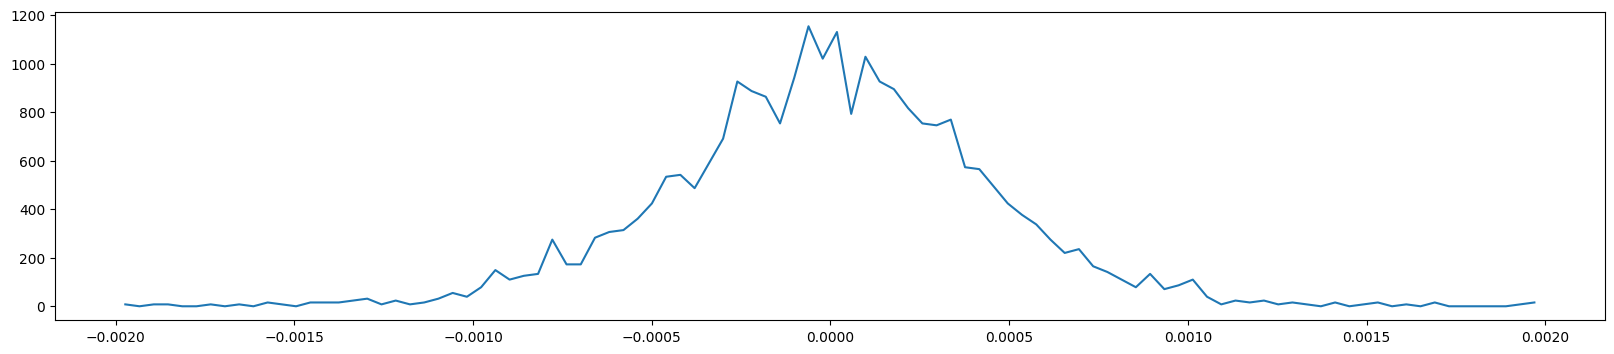

In [55]:
# 1번째 레이어(Tanh) 그레디언트 그려보기
plt.figure(figsize=(20,4))

layer = layers[1]
t = layer.out.grad
print(f'layer 1 {layer.__class__.__name__:10s}: mean: {t.mean():+f}, std: {t.std():e}')
hy, hx = torch.histogram(t, density=True) # histogram count, bin edges
plt.plot(hx[:-1].detach(), hy.detach()) # hx가 hy보다 숫자 하나 더 많아서 맞춰줍니다.

layer 1 (Tanh      ): mean: +0.000011, std: 4.397009e-04
layer 3 (Tanh      ): mean: +0.000017, std: 4.175974e-04
layer 5 (Tanh      ): mean: +0.000006, std: 3.835029e-04
layer 7 (Tanh      ): mean: +0.000008, std: 3.404981e-04
layer 9 (Tanh      ): mean: +0.000009, std: 3.022751e-04


Text(0.5, 1.0, 'gradient distribution')

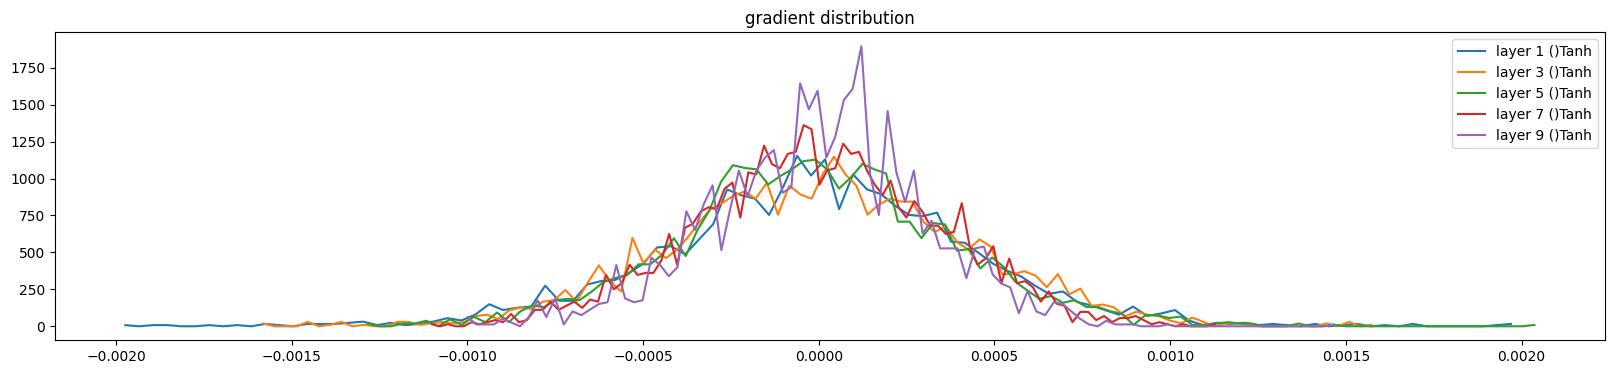

In [56]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__:10s}): mean: {t.mean():+f}, std: {t.std():e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

그레디언트 분포가 크게 바뀌지 않습니다

## 가중치 gain을 작게하면 분산 줄어듦
### 첫번째 스텝

In [57]:
vocab_size = 27
n_embed = 10
block_size = 3
n_hidden = 100

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain of tanh
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 0.5 # 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [58]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # for debugging
    for p in parameters:
        p.grad=None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break # for debugging

      0/ 200000: 3.2963


layer 1 Tanh      : mean: -0.03, std: 0.41, saturated: 0.00%
layer 3 Tanh      : mean: 0.00, std: 0.19, saturated: 0.00%
layer 5 Tanh      : mean: 0.00, std: 0.10, saturated: 0.00%
layer 7 Tanh      : mean: 0.00, std: 0.05, saturated: 0.00%
layer 9 Tanh      : mean: 0.00, std: 0.02, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

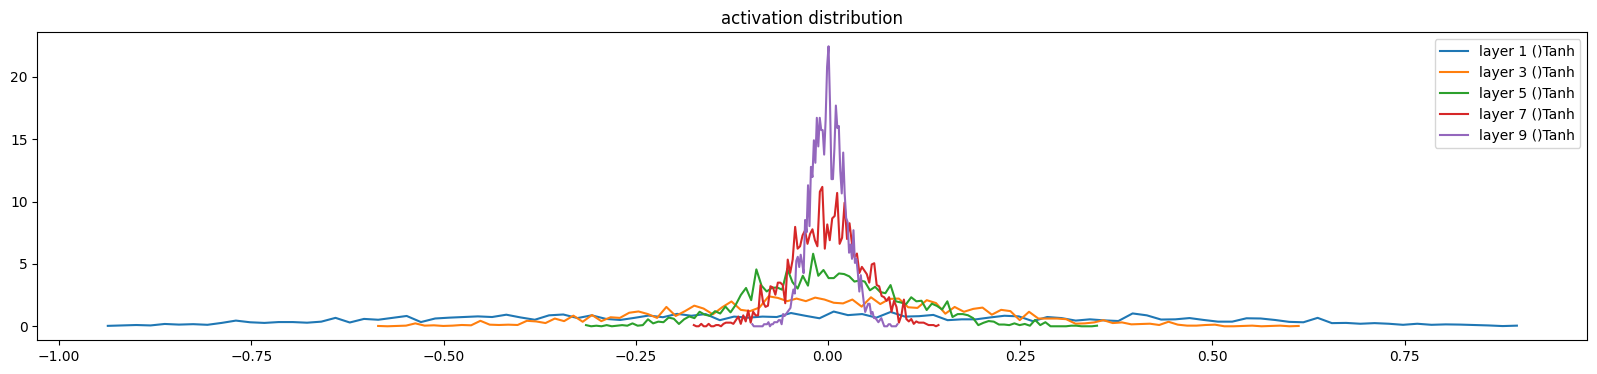

In [59]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} {layer.__class__.__name__:10s}: mean: {t.mean():.2f}, std: {t.std():.2f}, saturated: {(t.abs()>0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

레이어를 거칠수록 분산이 작아집니다

layer 1 (Tanh      ): mean: +0.000001, std: 1.872084e-05
layer 3 (Tanh      ): mean: +0.000001, std: 3.891321e-05
layer 5 (Tanh      ): mean: +0.000002, std: 7.837317e-05
layer 7 (Tanh      ): mean: +0.000004, std: 1.542801e-04
layer 9 (Tanh      ): mean: +0.000009, std: 3.018769e-04


Text(0.5, 1.0, 'gradient distribution')

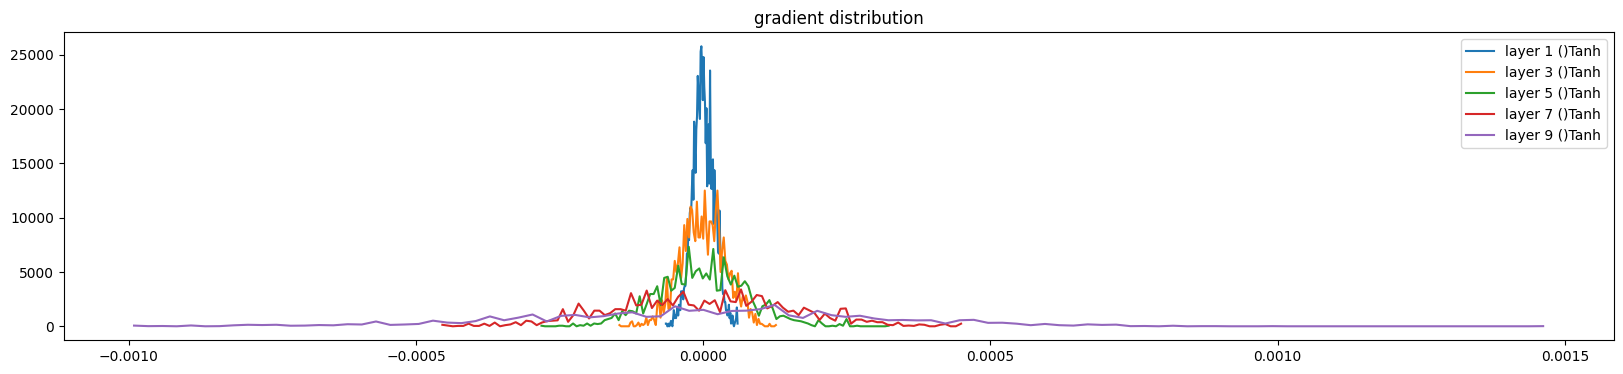

In [60]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__:10s}): mean: {t.mean():+f}, std: {t.std():e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

레이어를 거칠수록 그레디언트 분산은 커집니다

$z = \text{tanh}(wx+b)$라면

$\Large\frac{\partial loss}{\partial x} = W^T(1-z^2)\frac{\partial loss}{\partial z}$

## 5000스텝

In [61]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # for debugging
    for p in parameters:
        p.grad=None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    if i==5000: break # for debugging

      0/ 200000: 3.2935


layer 1 Tanh      : mean: -0.04, std: 0.57, saturated: 1.94%
layer 3 Tanh      : mean: 0.00, std: 0.48, saturated: 0.53%
layer 5 Tanh      : mean: 0.00, std: 0.47, saturated: 0.44%
layer 7 Tanh      : mean: -0.01, std: 0.47, saturated: 0.44%
layer 9 Tanh      : mean: -0.01, std: 0.43, saturated: 1.22%


Text(0.5, 1.0, 'activation distribution')

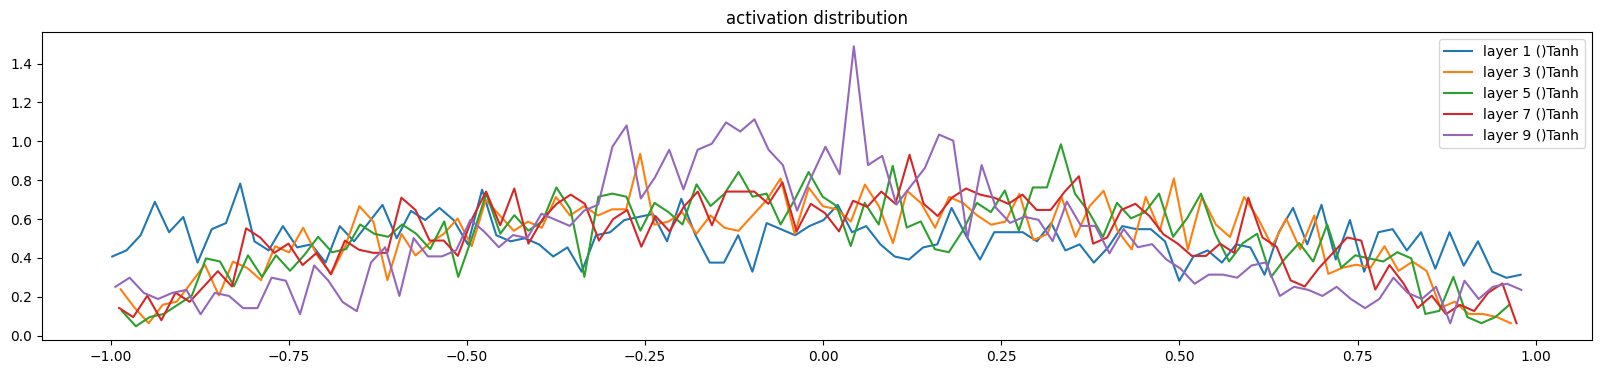

In [62]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} {layer.__class__.__name__:10s}: mean: {t.mean():.2f}, std: {t.std():.2f}, saturated: {(t.abs()>0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

layer 1 (Tanh      ): mean: -0.000028, std: 2.541912e-03
layer 3 (Tanh      ): mean: +0.000039, std: 1.918392e-03
layer 5 (Tanh      ): mean: -0.000005, std: 1.881008e-03
layer 7 (Tanh      ): mean: +0.000066, std: 2.047063e-03
layer 9 (Tanh      ): mean: -0.000030, std: 2.619531e-03


Text(0.5, 1.0, 'gradient distribution')

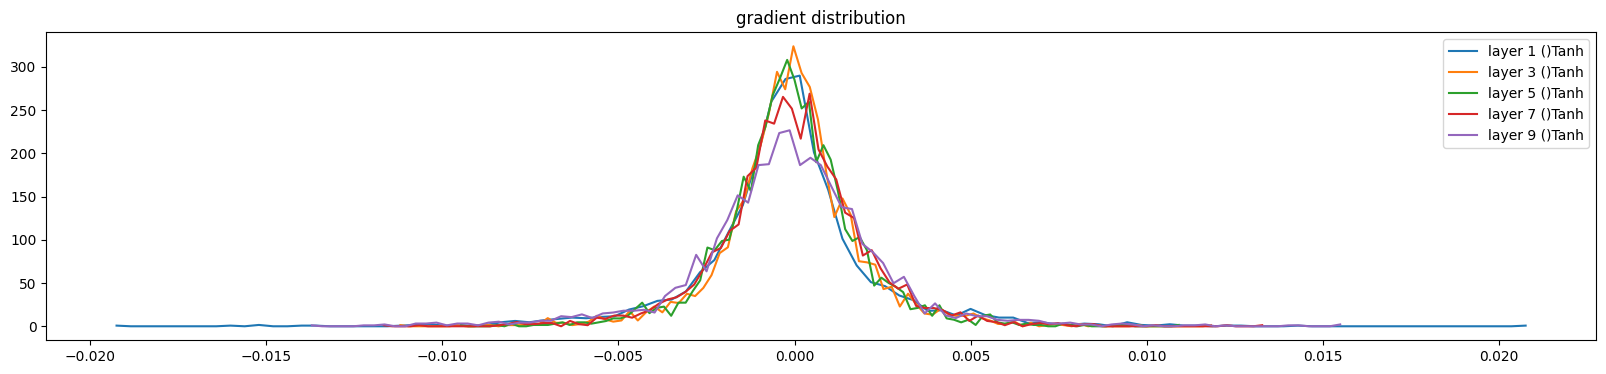

In [63]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__:10s}): mean: {t.mean():+f}, std: {t.std():e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

## 가중치 gain을 크게하면 분산 커짐

In [64]:
vocab_size = 27
n_embed = 10
block_size = 3
n_hidden = 100

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain of tanh
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 3 # 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [65]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # for debugging
    for p in parameters:
        p.grad=None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break # for debugging

      0/ 200000: 3.3228


layer 1 Tanh      : mean: -0.06, std: 0.85, saturated: 48.75%
layer 3 Tanh      : mean: 0.02, std: 0.84, saturated: 41.03%
layer 5 Tanh      : mean: 0.01, std: 0.84, saturated: 42.41%
layer 7 Tanh      : mean: -0.02, std: 0.84, saturated: 40.34%
layer 9 Tanh      : mean: 0.00, std: 0.84, saturated: 40.19%


Text(0.5, 1.0, 'activation distribution')

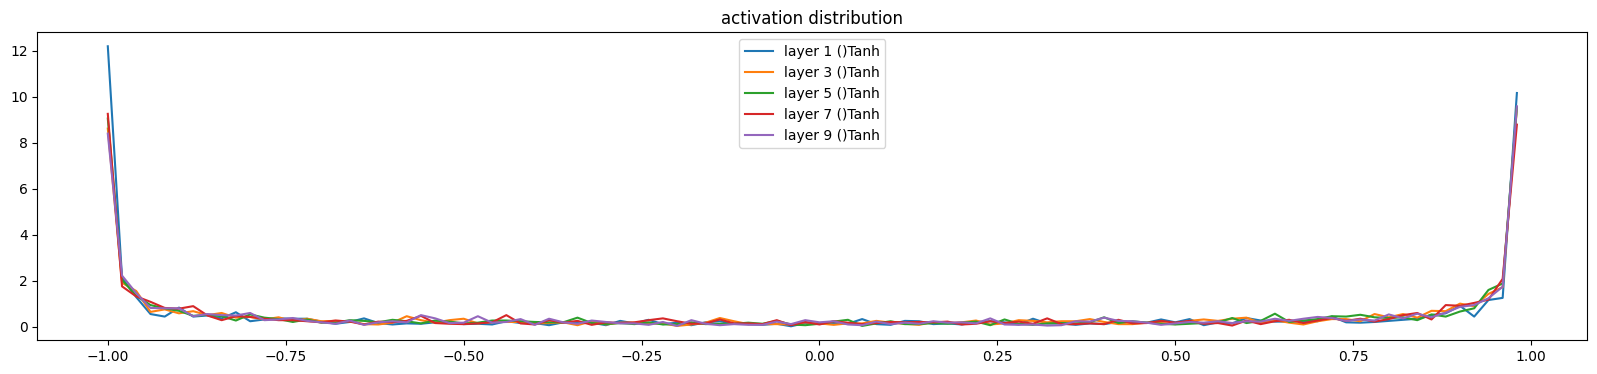

In [66]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} {layer.__class__.__name__:10s}: mean: {t.mean():.2f}, std: {t.std():.2f}, saturated: {(t.abs()>0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

In [68]:
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    # if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} {layer.__class__.__name__:10s}: mean: {t.mean():.2f}, std: {t.std():.2f}, saturated: {(t.abs()>0.97).float().mean()*100:.2f}%')

layer 0 Linear    : mean: -0.24, std: 2.92, saturated: 72.72%
layer 1 Tanh      : mean: -0.06, std: 0.85, saturated: 48.75%
layer 2 Linear    : mean: 0.05, std: 2.52, saturated: 70.72%
layer 3 Tanh      : mean: 0.02, std: 0.84, saturated: 41.03%
layer 4 Linear    : mean: 0.03, std: 2.54, saturated: 70.72%
layer 5 Tanh      : mean: 0.01, std: 0.84, saturated: 42.41%
layer 6 Linear    : mean: -0.04, std: 2.48, saturated: 70.88%
layer 7 Tanh      : mean: -0.02, std: 0.84, saturated: 40.34%
layer 8 Linear    : mean: 0.05, std: 2.50, saturated: 70.22%
layer 9 Tanh      : mean: 0.00, std: 0.84, saturated: 40.19%


layer 1 (Tanh      ): mean: +0.000007, std: 1.246991e-03
layer 3 (Tanh      ): mean: +0.000037, std: 8.942004e-04
layer 5 (Tanh      ): mean: +0.000010, std: 6.363824e-04
layer 7 (Tanh      ): mean: +0.000012, std: 4.300018e-04
layer 9 (Tanh      ): mean: +0.000009, std: 3.024140e-04


Text(0.5, 1.0, 'gradient distribution')

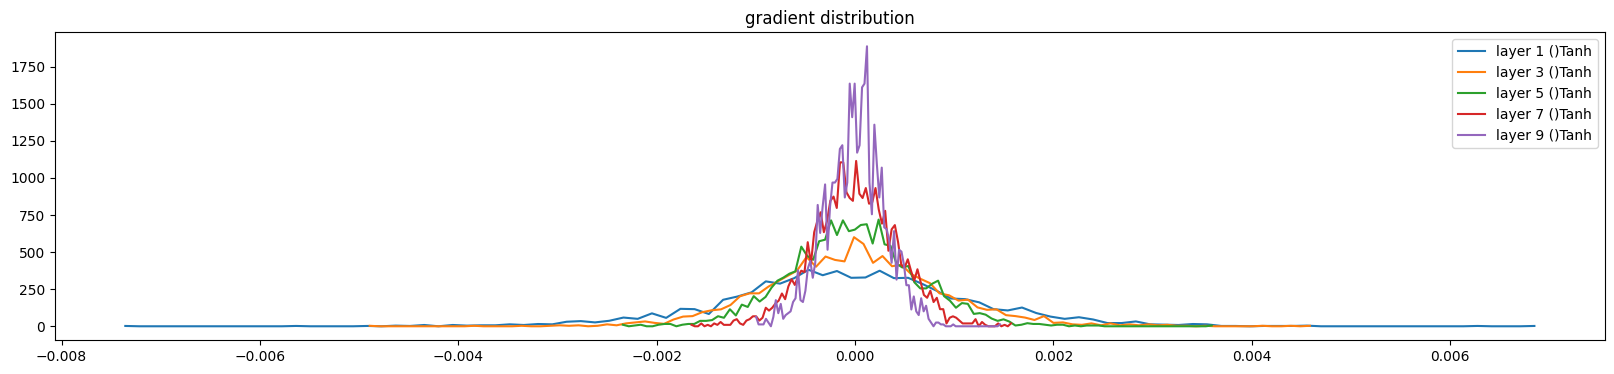

In [67]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__:10s}): mean: {t.mean():+f}, std: {t.std():e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')